In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt


from scipy.optimize import broyden1

from edpyt.shared import params
from edpyt.espace import build_espace, screen_espace
from edpyt.gf2_lanczos import build_gf2_lanczos
# new_path = '/capstor/scratch/cscs/ajayaraj/qtpyt-tests/pentadienyl'
# os.chdir(new_path)

In [2]:
# === Load inputs ===
input_folder = "../output_production_run/lowdin"
output_folder = "../output_production_run/lowdin/ed"
os.makedirs(output_folder, exist_ok=True)
sigma_ref = np.load("../reference/sigma_ed.npy")
np.round(sigma_ref[0],5)

H_eff = np.load(f"{input_folder}/effective_hamiltonian.npy")
occupancy_goal = np.load(f"{input_folder}/occupancies.npy")
V = np.loadtxt(f"{input_folder}/U_matrix.txt")

# === Parameters ===
nimp = H_eff.shape[0]
eta = 1e-3
beta = 1000

# === Initial double counting ===
DC0 = np.diag(V.diagonal() * (occupancy_goal - 0.5))
neig = np.ones((nimp + 1) * (nimp + 1), int) * 6

params["z"] = occupancy_goal

# Precompute reference ratio structure
dc0_diag = DC0.diagonal()

# Initial guess
x0 = dc0_diag.copy()


In [3]:
class Sigma2:
    def __init__(self, gf0, gf, H_eff, eta=1e-5):
        self.gf0 = gf0
        self.gf = gf
        self.eta = eta
        self.H_eff = H_eff

    def retarded(self, energy):
        energies = np.atleast_1d(energy)
        g0 = self.gf0(energies, self.eta)
        g = self.gf(energies, self.eta)
        sigma = np.empty((energies.size, self.gf.n, self.gf.n), complex)
        for e, energy in enumerate(energies):
            sigma[e] = np.linalg.inv(g0[..., e]) - np.linalg.inv(g[..., e])
        return sigma


class Sigma:

    def __init__(self, gf, H_eff, eta=1e-5):
        self.gf = gf
        self.eta = eta
        self.H_eff = H_eff

    def retarded(self, energy):
        energies = np.atleast_1d(energy)
        g = self.gf(energies, self.eta)
        sigma = np.empty((energies.size,self.gf.n,self.gf.n), complex)
        for e, energy in enumerate(energies):
            sigma[e] = energy - self.H_eff - np.linalg.inv(g[...,e])
        return sigma


def residual_function(dc_diag):
    # Clip only the lower bound
    dc_diag = np.clip(dc_diag, 0.0, np.inf)

    DC = np.diag(dc_diag)
    espace, egs = build_espace(H_eff - DC, V, neig_sector=neig)
    screen_espace(espace, egs, beta)
    gf = build_gf2_lanczos(H_eff - DC, V, espace, beta, egs)
    sigma = Sigma( gf, H_eff, eta=eta)

    # Get physical residual from Σ at large negative frequency
    energies = np.array([-1.0])
    sig_cost = sigma.retarded(energies)
    sig_real_diag = sig_cost.real.diagonal(axis1=1, axis2=2)
    residual = np.sum(sig_real_diag, axis=0)

    # Logging
    residual_norm = np.linalg.norm(residual)
    print(f"[Broyden] Residual norm: {residual_norm:.6e}, DC_diag: {dc_diag}")

    return residual

In [5]:
espace, egs = build_espace(H_eff, np.zeros_like(H_eff), neig_sector=neig)
screen_espace(espace, egs, beta)
gf0 = build_gf2_lanczos(H_eff, np.zeros_like(H_eff), espace, beta, egs)

KeyboardInterrupt: 

In [4]:
espace, egs = build_espace(H_eff - DC0, V, neig_sector=neig)
screen_espace(espace, egs, beta)
gf = build_gf2_lanczos(H_eff - DC0, V, espace, beta, egs)


In [5]:
de = 0.01
energies = np.arange(-100, 100 + de / 2.0, de).round(7)
eta = 1e-3

In [6]:
sigma = Sigma(gf, H_eff, eta=3e-2)
sigma_ret = sigma.retarded(energies)
np.save(f"{output_folder}/sigma_abinit.npy", sigma_ret)

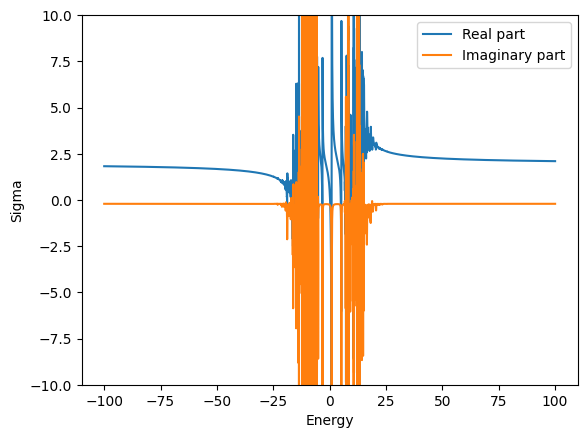

In [7]:
sigma_ret_trace = np.trace(sigma_ret, axis1=1, axis2=2)
plt.plot(energies, sigma_ret_trace.real, label="Real part")
plt.plot(energies, sigma_ret_trace.imag, label="Imaginary part")
plt.plot
plt.xlabel("Energy")
plt.ylabel("Sigma")
# plt.xlim(75,100)
plt.ylim(-10,10)
plt.legend()

In [8]:
print(sigma_ret_trace[0])
print(sigma_ret_trace[-1])

(1.8239862116656695-0.21004251796933016j)
(2.0977335586061656-0.21004152391244235j)


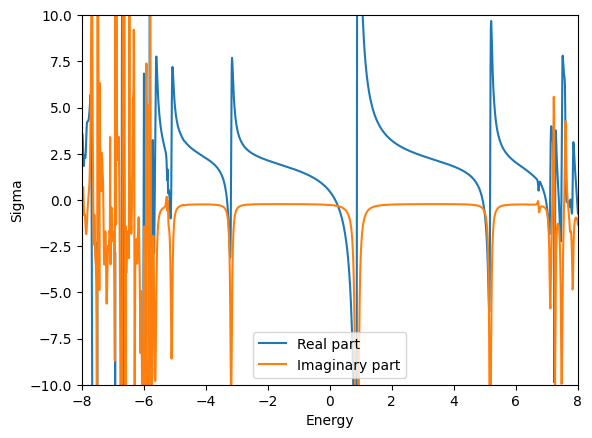

In [ ]:
sigma2 = Sigma2(gf, H_eff, eta=3e-2)
sigma_ret2 = sigma2.retarded(energies)
# np.save(f"{output_folder}/sigma_abinit.npy", sigma_ret)


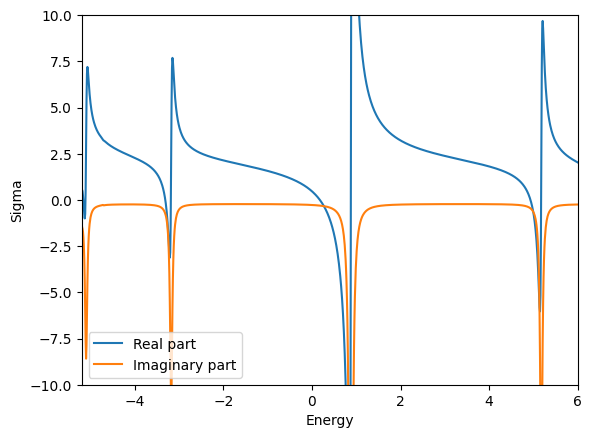

In [ ]:
sigma_ret_trace2 = np.trace(sigma_ret2, axis1=1, axis2=2)
plt.plot(energies, sigma_ret_trace2.real, label="Real part")
plt.plot(energies, sigma_ret_trace2.imag, label="Imaginary part")
plt.plot
plt.xlabel("Energy")
plt.ylabel("Sigma")
plt.ylim(-10, 10)
plt.xlim(-5.2,6)
plt.legend()

## Optimization routine

In [79]:
dc_diag_optimized = broyden1(
    residual_function,
    x0,
    f_tol=1e-3,
    maxiter=50,
    verbose=True,
)

[Broyden] Residual norm: 2.114902e+00, DC_diag: [5.46515887 1.97886514 2.52035611 2.22202704 2.7152016  2.12250731
 5.90703705]
[Broyden] Residual norm: 2.362296e+00, DC_diag: [3.11307469 3.28217026 4.23748965 3.7732374  4.5134989  3.76731898
 3.80085714]
[Broyden] Residual norm: 2.784512e-01, DC_diag: [4.52254297 2.50117473 3.20851064 2.84368657 3.43588313 2.78167829
 5.06296919]
0:  |F(x)| = 0.151262; step 0.400758
[Broyden] Residual norm: 1.683121e-01, DC_diag: [4.44489596 2.4590732  3.42138892 3.01129126 3.67796451 2.70982219
 4.97293117]
1:  |F(x)| = 0.119863; step 1
[Broyden] Residual norm: 9.861978e-02, DC_diag: [4.41136119 2.55134217 3.33959801 3.01924605 3.56878418 2.86848879
 4.94874025]
2:  |F(x)| = 0.0670133; step 1
[Broyden] Residual norm: 4.094316e-02, DC_diag: [4.3979653  2.52910658 3.36982129 2.96484483 3.61795738 2.80483911
 4.94415642]
3:  |F(x)| = 0.0345809; step 1
[Broyden] Residual norm: 1.963286e-02, DC_diag: [4.41691468 2.5258762  3.36814621 3.00998703 3.60656749

In [32]:
dc_diag_optimized = np.load(f"{output_folder}/ed_dcc_diag_-1ev.npy")
DC = np.diag(dc_diag_optimized)
espace, egs = build_espace(H_eff - DC, V, neig_sector=neig)
screen_espace(espace, egs, beta)
gf = build_gf2_lanczos(H_eff - DC, V, espace, beta, egs)
sigma = Sigma( gf, H_eff, eta=3e-2)
sigma_ret = sigma.retarded(energies)
sigma_ret_trace = np.trace(sigma_ret, axis1=1, axis2=2)

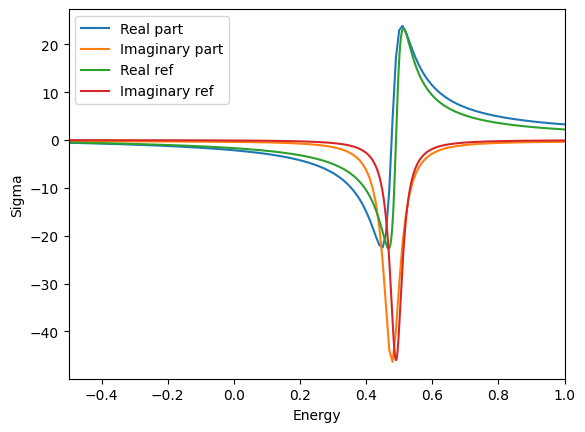

In [86]:
sig_ref = np.load("./reference/sigma_ed_diag.npy")
sig_trace = np.sum(sig_ref, axis=0)
energies_ref = np.linspace(-0.5,1, 2000)

plt.plot(energies, sigma_ret_trace.real, label="Real part")
plt.plot(energies, sigma_ret_trace.imag, label="Imaginary part")
plt.plot(energies_ref,sig_trace.real, label="Real ref")
plt.plot(energies_ref,sig_trace.imag, label="Imaginary ref")
plt.plot
plt.xlabel("Energy")
plt.ylabel("Sigma")
plt.xlim(-0.5, 1)
# plt.ylim(-10,20)
plt.legend()

In [87]:
np.save(f"{output_folder}/ed_dcc_diag_-1ev.npy", dc_diag_optimized)